Script to process CAMS emission from burnt CO2 data to transform raw grib files (daily values) to annual Tn of burnt CO2 tiff files
STEPS:
1. Load raw grib files for each year
2. Conversion of units from kg/m2s to annual Tn of burnt CO2
3. Align and reproject from 4326 to 3035
4. Rescale to 10km grid resolution

In [2]:
import xarray as xr
import pandas as pd
import os, glob
import numpy as np
import cfgrib

from matplotlib import pyplot as plt
import matplotlib.colors
from matplotlib.colors import LogNorm
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.feature as cfeature
import matplotlib.cm as cm

import rioxarray as rio
import rasterio
from rasterio.crs import CRS
from rasterio.enums import Resampling
from rasterio.warp import reproject

from osgeo import gdal, ogr, osr

In [10]:
# list of grib files in the input folder
infiles = glob.glob('./Data/rawdata/burntCO2/*.grib', recursive = True)
for file in infiles:
    year = file.split('\\')[-1].split('.')[0].split('_')[1]
    outfile = './Data/output/co2fire{}_Tnyear_3035.tif'.format(year)
    
    if not os.path.exists(outfile):   
        print('running year {}'.format(year))

        # open dataset
        ds = xr.open_dataset(file, engine='cfgrib')

        # sum total burnt carbon in a given year
        csum = ds.co2fire.sum(dim = "time") 

        # Conversion from  kg m**-2 s**-1 to Megatonnes of Carbon burnt in a year
        # 1 day = 86400 s
        # 1 pixel = 10000*10000 m2 (final output resolution)
        # 1000 kg = 1 Tn  
        csum_Tn = csum * 8640000000 # conversion from kg/m2s to annual Tn of burnt carbon 
        ## csum_Mt = csum * 8640 # conversion from kg/m2s to annual Mt of burnt carbon 

        # create temp tif
        csum_tif = csum_Tn.fillna(-999) # fill with no data value '-999'
        csum_tif.rio.write_crs("epsg:4326") # set crs
        tempfile = './Data/tempCO2/co2fire{}_Tnyear_4326.tif'.format(year)
        csum_tif.rio.to_raster(tempfile, compress='LZW')

        # align file and reproject to LAEA
        source = gdal.Open(tempfile)
        xmin = round(csum_tif.rio.bounds()[0]/10000)*10000
        ymin = round(csum_tif.rio.bounds()[1]/10000)*10000
        xmax = round(csum_tif.rio.bounds()[2]/10000)*10000
        ymax = round(csum_tif.rio.bounds()[3]/10000)*10000

        gdal.Warp(outfile, source, format = 'GTiff',
                  xRes=10000, yRes=10000, 
                  outputBounds = [xmin, ymin, xmax, ymax], 
                  targetAlignedPixels=True, dstNodata = -9999,
                  srcSRS='EPSG:4326', dstSRS = 'EPSG:3035',
                  outputType = gdal.GDT_UInt32,
                  resampleAlg = gdal.GRIORA_Bilinear)
    
        ds.close()

running year 2004
running year 2005
running year 2006
running year 2007
running year 2008
running year 2009
running year 2010
running year 2011
running year 2012
running year 2013
running year 2014
running year 2015
running year 2016
running year 2017
running year 2018
running year 2019
running year 2020
running year 2021
running year 2022


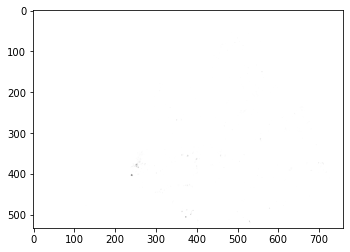

In [26]:
from matplotlib import pyplot

# list of grib files in the input folder
infiles = glob.glob('./Data/rawdata/burntCO2/*.grib', recursive = True)
for file in infiles[:1]:
    year = file.split('\\')[-1].split('.')[0].split('_')[1]
    outfile = './Data/output/co2fire{}_Tnyear_3035.tif'.format(year)

    src = rasterio.open(outfile)
    array = src.read(1)
    pyplot.imshow(array, cmap='gist_yarg')
    pyplot.show()
    array.min()
    

#raster[raster >= 13776] = 0
#raster

In [14]:
array.max()

698866

In [13]:
array.min()

0